When benchmarking you **MUST**

1. close all applications
2. close docker
3. close all but this Web windows
4. all pen editors other than jupyter-lab (this notebook)


In [1]:
import os
from cloudmesh.common.Shell import Shell
from pprint import pprint
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import pandas as pd
from tqdm.notebook import tqdm
from cloudmesh.common.util import readfile
from cloudmesh.common.util import writefile
from cloudmesh.common.StopWatch import StopWatch 
from cloudmesh.common.systeminfo import systeminfo
import ipywidgets as widgets

sns.set_theme(style="whitegrid")
info = systeminfo()

In [2]:

user = info["user"] 
node = info["uname.node"]
processors = 4

In [3]:
# Parameters
user = "gregor"
node = "i5"
processors = 4


In [4]:
p = widgets.IntSlider(
    value=processors,
    min=2,
    max=64,
    step=1,
    description='Processors:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d'
)
u = widgets.Text(value=user, placeholder='The user name', description='User:', disabled=False)
n = widgets.Text(value=node, placeholder='The computer name', description='Computer:', disabled=False)

display(p)
display(u)
display(n)

IntSlider(value=4, continuous_update=False, description='Processors:', max=64, min=2)

Text(value='gregor', description='User:', placeholder='The user name')

Text(value='i5', description='Computer:', placeholder='The computer name')

In [5]:
processors = p.value
user = u.value
node = n.value
print (processors, user, node)

4 gregor i5


In [6]:

experiments = 10
maximum = 1024 * 100000
intervals = 10

In [7]:
label = f"{user}-{node}-{processors}"
output = f"benchmark/{user}"

delta = int(maximum / intervals)

totals = [64] + list(range(0,maximum, delta))[1:]
points = [int(t/processors) for t in totals]
print (totals)
print(points)

[64, 10240000, 20480000, 30720000, 40960000, 51200000, 61440000, 71680000, 81920000, 92160000]
[16, 2560000, 5120000, 7680000, 10240000, 12800000, 15360000, 17920000, 20480000, 23040000]


In [8]:
os.makedirs(output, exist_ok=True)

In [9]:
systeminfo = StopWatch.systeminfo({"user": user, "uname.node": node})
writefile(f"{output}/{label}-sysinfo.log", systeminfo)
print (systeminfo)

+---------------------+------------------------------------------------------------------+
| Attribute           | Value                                                            |
|---------------------+------------------------------------------------------------------|
| BUG_REPORT_URL      | "https://bugs.launchpad.net/ubuntu/"                             |
| DISTRIB_CODENAME    | hirsute                                                          |
| DISTRIB_DESCRIPTION | "Ubuntu 21.04"                                                   |
| DISTRIB_ID          | Ubuntu                                                           |
| DISTRIB_RELEASE     | 21.04                                                            |
| HOME_URL            | "https://www.ubuntu.com/"                                        |
| ID                  | ubuntu                                                           |
| ID_LIKE             | debian                                                           |

In [10]:
df = pd.DataFrame(
{"Size": points}
)
df = df.set_index('Size')

In [11]:


experiment_progress = tqdm(range(0, experiments), desc ="Experiment")

experiment = -1
for experiment in experiment_progress:
    exoeriment = experiment + 1

    log = f"{output}/{label}-{experiment}-log.log"
    os.system(f"rm {log}")


    name = points[experiment]
    progress = tqdm(range(0, len(points)), 
                    desc =f"Benchmark {name}",
                    bar_format="{desc:<30} {total_fmt} {r_bar}")
    
    i = -1
    for state in progress:
        i = i + 1
        n = points[i]
        #if linux, os:
        command = f"mpiexec -n {processors} python count-click.py " + \
                  f"--n {n} --max_number 10 --find 8 --label {label} " + \
                  f"--user {user} --node={node} " + \
                  f"| tee -a {log}"
        #if windows: 
        #command = f"mpiexec -n {processors} python count-click.py " + \
        #          f"--n {n} --max_number 10 --find 8 --label {label} " + \
        #          f"--user {user} --node={node} " + \
        #          f">> {log}"
        
        os.system (command)

    content = readfile(log).splitlines()
    lines = Shell.cm_grep(content, "csv,Result:")
    # print(lines)
    values = []
    times = []

    for line in lines:
        msg = line.split(",")[7]
        t = line.split(",")[4]

        total, overall, trials, find, label = msg.split(" ")
        values.append(int(overall))
        times.append(float(t))
        # print (t, overall)


    #data = pd.DataFrame(values, times, columns=["Values", "Time"])

    #print (data.describe())
    #sns.lineplot(data=data, palette="tab10", linewidth=2.5)
    # df["Size"] = values
    df[f"Time_{experiment}"] = times
    # print(df)


Experiment:   0%|          | 0/10 [00:00<?, ?it/s]

Benchmark 16                   10 | 0/10 [00:00<?, ?it/s]

Benchmark 2560000              10 | 0/10 [00:00<?, ?it/s]

Benchmark 5120000              10 | 0/10 [00:00<?, ?it/s]

Benchmark 7680000              10 | 0/10 [00:00<?, ?it/s]

Benchmark 10240000             10 | 0/10 [00:00<?, ?it/s]

Benchmark 12800000             10 | 0/10 [00:00<?, ?it/s]

Benchmark 15360000             10 | 0/10 [00:00<?, ?it/s]

Benchmark 17920000             10 | 0/10 [00:00<?, ?it/s]

Benchmark 20480000             10 | 0/10 [00:00<?, ?it/s]

Benchmark 23040000             10 | 0/10 [00:00<?, ?it/s]

In [12]:

df = df.rename_axis(columns="Time")
df
    

Time,Time_0,Time_1,Time_2,Time_3,Time_4,Time_5,Time_6,Time_7,Time_8,Time_9
Size,,,,,,,,,,
16,0.001,0.001,0.000,0.000,0.000,0.001,0.002,0.000,0.002,0.001
2560000,1.407,1.452,1.440,1.466,1.422,1.428,1.411,1.433,1.409,1.413
5120000,2.815,2.851,2.800,2.824,2.802,2.876,2.815,2.910,2.876,2.803
7680000,4.339,4.301,4.228,4.223,4.245,4.234,4.419,4.305,4.300,4.216
10240000,5.663,5.658,5.674,5.635,5.654,5.652,5.780,5.819,5.702,5.591
12800000,7.018,7.062,7.112,7.131,7.259,7.085,7.200,7.073,7.000,7.054
15360000,8.523,8.569,8.479,8.423,8.480,8.521,8.497,8.513,8.439,8.429
17920000,9.843,9.788,10.073,10.031,9.884,9.960,10.219,9.739,9.971,9.840
20480000,11.120,11.306,11.386,11.289,11.283,11.191,11.228,11.181,11.309,11.525


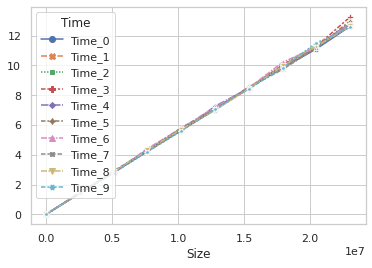

In [13]:
sns.lineplot(data=df, markers=True);

In [14]:
plt.savefig(f'{output}/{label}-line.png');
plt.savefig(f'{output}/{label}-line.pdf');

<Figure size 432x288 with 0 Axes>

In [15]:
dfs = df.stack().reset_index()
dfs = dfs.set_index('Size')
dfs = dfs.drop(columns=['Time'])
dfs = dfs.rename(columns={0:'Time'})
dfs

,Time
Size,
16,0.001
16,0.001
16,0.000
16,0.000
16,0.000
...,...
23040000,13.009
23040000,12.816
23040000,12.736


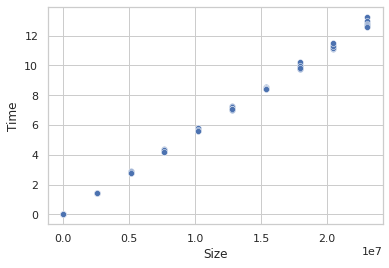

In [16]:
sns.scatterplot(data=dfs, x="Size", y="Time");
plt.savefig(f"{output}/{label}-scatter.pdf")
plt.savefig(f"{output}/{label}-scatter.png")

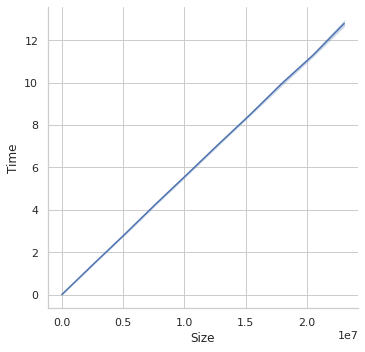

In [17]:
sns.relplot(x="Size", y="Time", kind="line", data=dfs);
plt.savefig(f"{output}/{label}-relplot.pdf")
plt.savefig(f"{output}/{label}-relplot.png")

In [18]:
df.to_pickle(f"{output}/{label}-df.pkl")